In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [5]:
# load the df
final_df = pd.read_csv("final_team_df.csv")

# view the df
final_df.head()

,gameid,participantid,pick1,pick2,pick3,pick4,pick5,result,year,Games,...,OppPick_Yone,OppPick_Yorick,OppPick_Yuumi,OppPick_Zac,OppPick_Zed,OppPick_Zeri,OppPick_Ziggs,OppPick_Zilean,OppPick_Zoe,OppPick_Zyra
0,ESPORTSTMNT06/20195,100,Varus,Olaf,Miss Fortune,Nautilus,Aurelion Sol,1,2017,47,...,0,0,0,0,0,0,0,0,0,1
1,ESPORTSTMNT06/20207,200,Ashe,Olaf,Miss Fortune,Taliyah,Nautilus,0,2017,47,...,0,0,0,0,0,0,0,0,0,1
2,ESPORTSTMNT06/20215,100,Ryze,Olaf,Malzahar,Caitlyn,Nautilus,0,2017,47,...,0,0,0,0,0,0,0,0,0,1
3,ESPORTSTMNT06/70797,200,Jhin,Maokai,Graves,Corki,Lulu,0,2017,47,...,0,0,0,0,0,0,0,0,0,0
4,ESPORTSTMNT06/70831,100,Jhin,Shen,Rengar,Lulu,Syndra,0,2017,47,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# drop the columns that have been one hot encoded and drop gameid (for modeling process)
df = final_df.drop(
    columns=[
        "pick1",
        "pick2",
        "pick3",
        "pick4",
        "pick5",
        "opp_pick1",
        "opp_pick2",
        "opp_pick3",
        "opp_pick4",
        "opp_pick5",
        "gameid",
    ]
).dropna()

In [7]:
# normalize the numeric variables for better training
stats_columns = [col for col in df.columns if "stats_" in col]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
df[stats_columns] = scaler.fit_transform(df[stats_columns])

# Now df has the normalized statistics

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets first
X = df.drop("result", axis=1)
y = df["result"]

# 70% train, 20% validation, and 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Standardize the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit PCA on the scaled training data
pca = PCA(n_components=0.95)  # retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# Now, X_train_pca, X_val_pca, and X_test_pca can be used for training and evaluation

**Model Goes Here**

In [9]:
def create_model(neurons=32, learning_rate=0.001, extra_layers=0):
    model = Sequential()
    # Adjust input_dim to match the number of PCA components
    model.add(Dense(neurons, input_dim=X_train_pca.shape[1], activation="relu"))

    # Add extra hidden layers based on the extra_layers parameter
    for _ in range(extra_layers):
        model.add(Dense(neurons, activation="relu"))

    model.add(Dense(1, activation="sigmoid"))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [10]:
# Wrap the model with KerasClassifier
model = KerasClassifier(model=create_model, verbose=0, random_state=42)

param_grid = {
    "model__neurons": [32, 64, 128],  # expanded range of neurons
    "model__learning_rate": [
        0.001,
        0.005,
        0.01,
        0.05,
    ],  # finer range around lower values
    "model__extra_layers": [0, 1, 2, 3],  # testing more layers
}

In [11]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_pca, y_train)  # Use the PCA-transformed data

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [12]:
# Output the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.613995 using {'model__extra_layers': 2, 'model__learning_rate': 0.01, 'model__neurons': 32}
0.600019 (0.002136) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 32}
0.599544 (0.002745) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 64}
0.598807 (0.002109) with: {'model__extra_layers': 0, 'model__learning_rate': 0.001, 'model__neurons': 128}
0.610002 (0.001348) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 32}
0.603941 (0.003319) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 64}
0.589894 (0.004375) with: {'model__extra_layers': 0, 'model__learning_rate': 0.005, 'model__neurons': 128}
0.583856 (0.012376) with: {'model__extra_layers': 0, 'model__learning_rate': 0.01, 'model__neurons': 32}
0.586257 (0.006858) with: {'model__extra_layers': 0, 'model__learning_rate': 0.01, 'model__neurons': 64}
0.558471 (0.014558) with: {'model__extra_layers': 0,

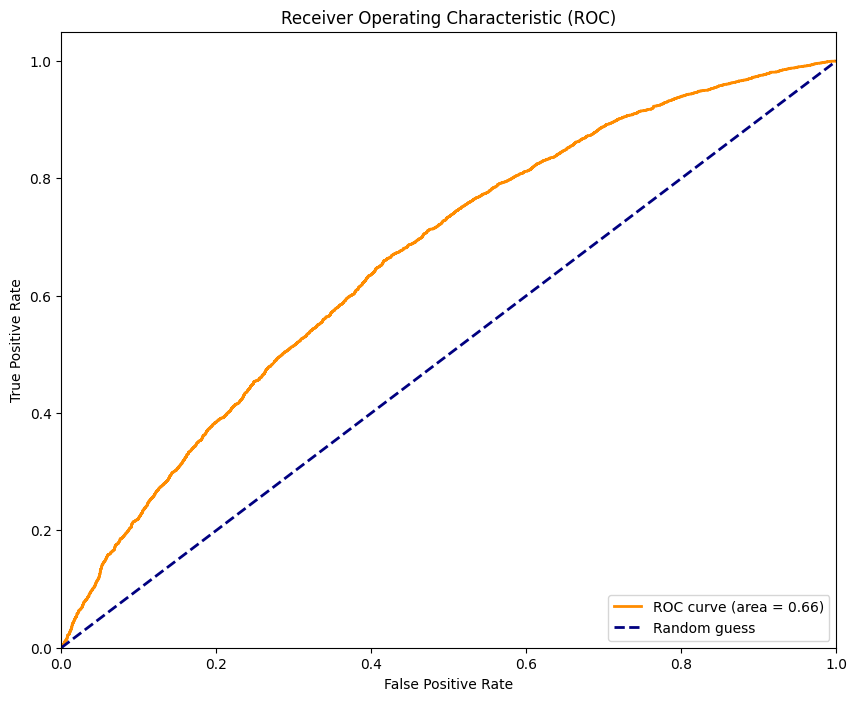

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have already run GridSearchCV and have the grid_result
best_model = grid_result.best_estimator_

# Predict probabilities for the test data using the best model from grid search
y_pred_probs = best_model.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)

# Plot the random guess line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random guess")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

y_pred_proba = grid_result.best_estimator_.predict_proba(X_test_pca)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC: {auc_score}")

Test AUC: 0.6627303538955993
